# Prepare custom dataset

In [39]:
# Copyright 2021 wngfra.
# SPDX-License-Identifier: Apache-2.0

import glob
import os
import re
import numpy as np
from bidict import bidict
from numpy.lib.stride_tricks import sliding_window_view
from torch.utils.data import Dataset
from torchvision import transforms

class Texture:
    """ Create a bidict from a texture name list."""

    def __init__(self, texture_names):
        self.texture_by_id = bidict()
        for i, tn in enumerate(set(texture_names)):
            self.texture_by_id[tn] = i

    def get_id(self, texture_name: str):
        return self.texture_by_id[texture_name]

    def get_name(self, texture_id: int):
        return self.texture_by_id.inverse[texture_id]


class TacDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.filelist = [y for x in os.walk(
            root_dir) for y in glob.glob(os.path.join(x[0], '*.csv'))]
        self.params = [(0.0, 0.0)] * len(self.filelist)
        self.texture_names = []
        for i, filename in enumerate(self.filelist):
            basename = os.path.basename(filename)
            namegroups = basename.split('_')

            self.texture_names.append(namegroups[0])
            self.params[i] = [int(re.search(r"\d+", namegroups[1]).group(0)),
                              float(re.search(r"[-+]?\d+", namegroups[2]).group(0))]
        self.textures = Texture(self.texture_names)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, index):
        filename = self.filelist[index]
        rawdata  = np.genfromtxt(filename, delimiter=',', skip_header=1)
        tacdata  = rawdata[:, 3:]
        texture_name = self.texture_names[index]
        if self.transform:
            tacdata = self.transform(tacdata)
        return tacdata, self.params[index], self.textures.get_id(texture_name)
    
    def count_class(self):
        return len(set(self.texture_names))

    def get_texture_name(self, texture_id):
        return self.textures.get_name(texture_id)

    
""" Custom transforms """

class Normalize(object):
    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, sample):
        return (sample - np.mean(sample, keepdims=True)) / np.std(sample, keepdims=True)
    
def fft_resample(x):
    axis = 0
    
    x = np.asarray(x)
    Nx = x.shape[axis]
    
    X = rfft(x, axis=axis, norm="ortho")
    
    # Placeholder array for output spectrum
    newshape = list(x.shape)
    newshape[0] = num // 2 + 1
    Y = np.zeros(newshape, X.dtype)

    # Copy positive frequency components (and Nyquist, if present)
    N = min(num, Nx)
    nyq = N // 2 + 1  # Slice index that includes Nyquist if present
    sl = [slice(None)] * x.ndim
    sl[axis] = slice(0, nyq)
    Y[tuple(sl)] = X[tuple(sl)]

    # Split/join Nyquist component(s) if present
    # So far we have set Y[+N/2]=X[+N/2]
    if N % 2 == 0:
        if num < Nx:  # downsampling
            sl[axis] = slice(N//2, N//2 + 1)
            Y[tuple(sl)] *= 2.
        elif Nx < num:  # upsampling
            # select the component at frequency +N/2 and halve it
            sl[axis] = slice(N//2, N//2 + 1)
            Y[tuple(sl)] *= 0.5
    
    Ys = np.abs(Y)[1:, :].flatten()
    return Ys

transform = transforms.Compose([Normalize(axis=1)])
ds = TacDataset('data', transform=transform)

# Figures for writing docs

<IPython.core.display.Javascript object>


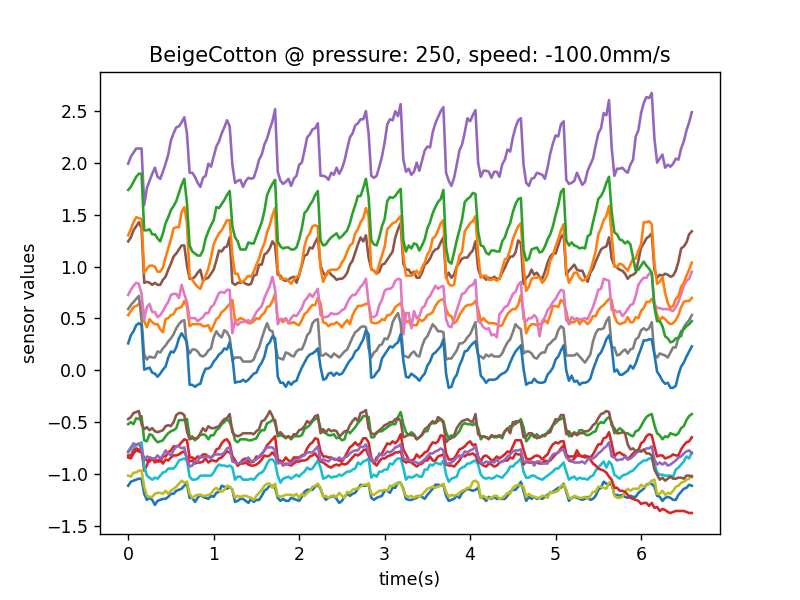

<IPython.core.display.Javascript object>


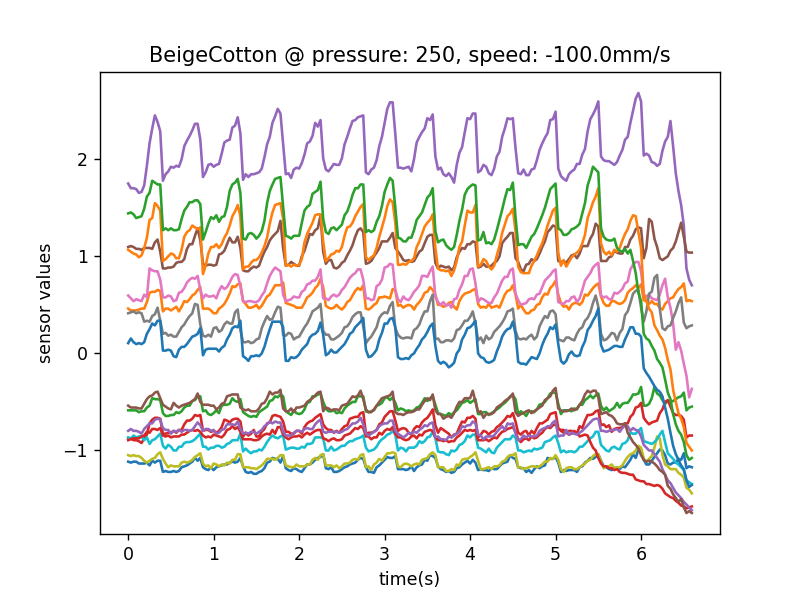

<IPython.core.display.Javascript object>


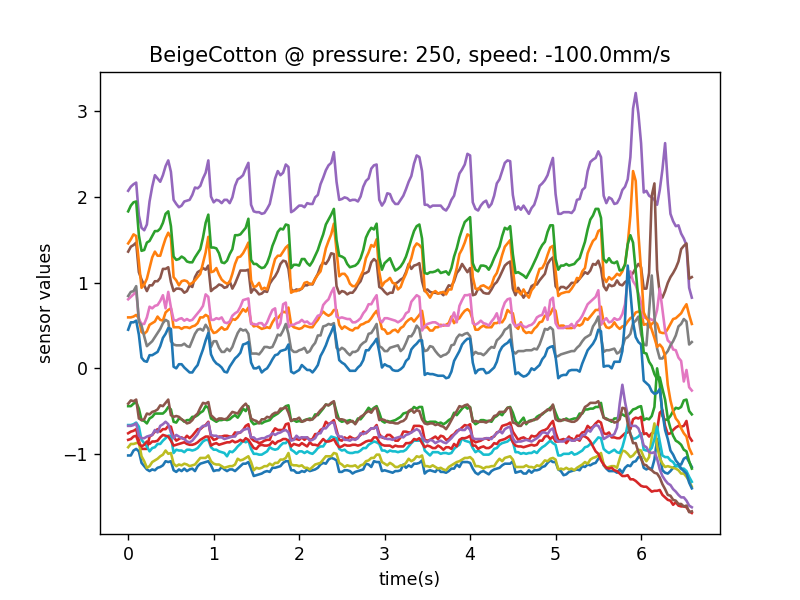

<IPython.core.display.Javascript object>


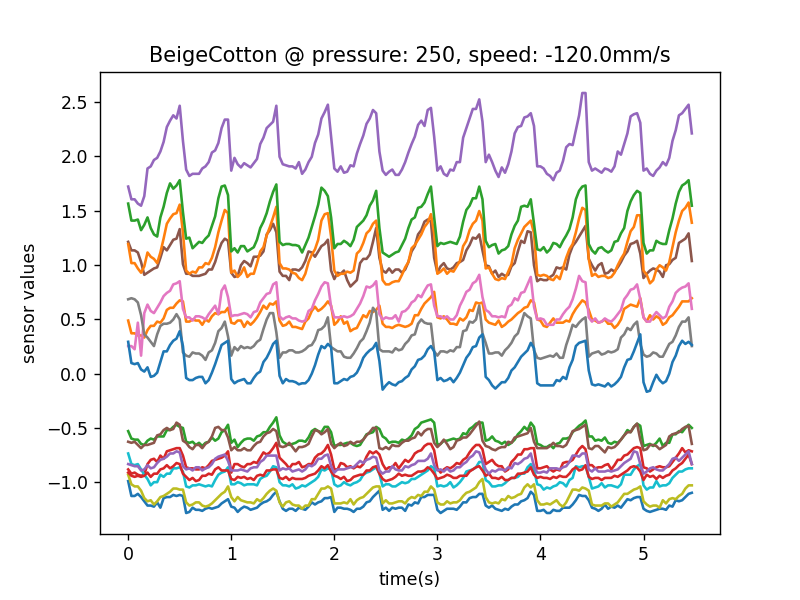

<IPython.core.display.Javascript object>


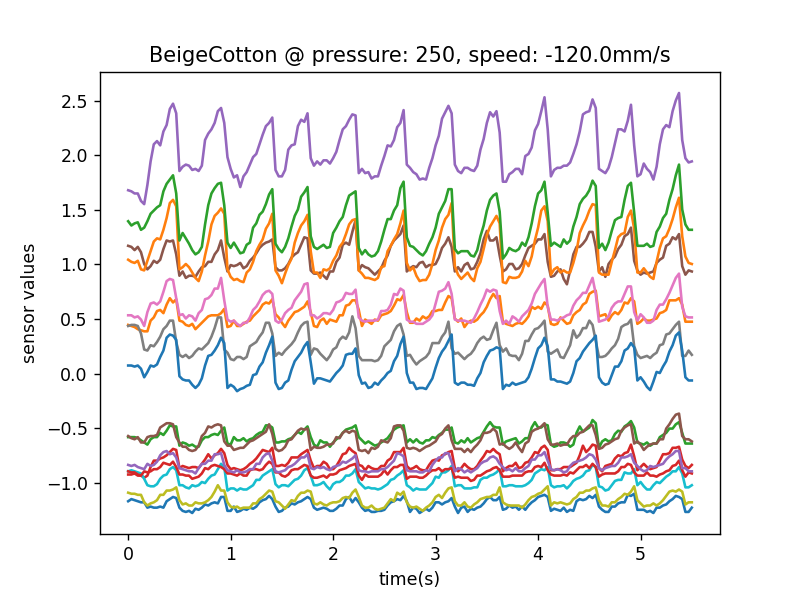

<IPython.core.display.Javascript object>


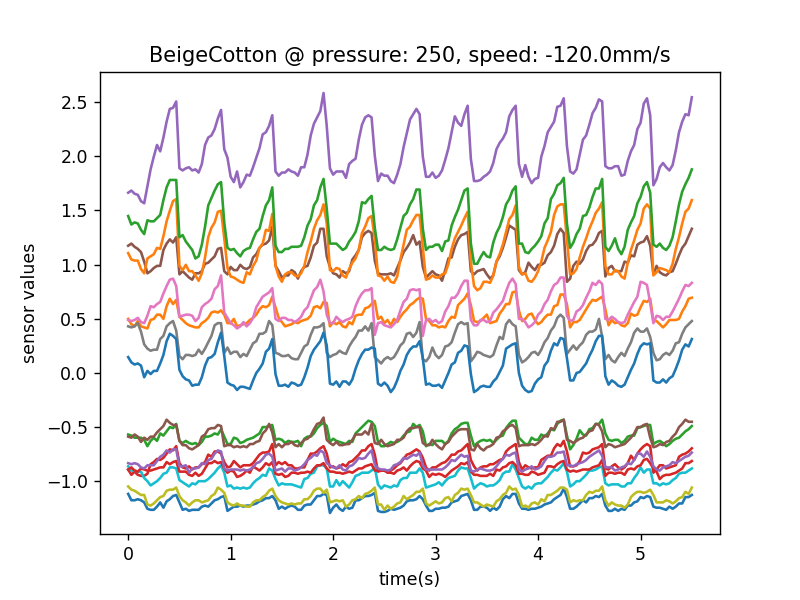

<IPython.core.display.Javascript object>


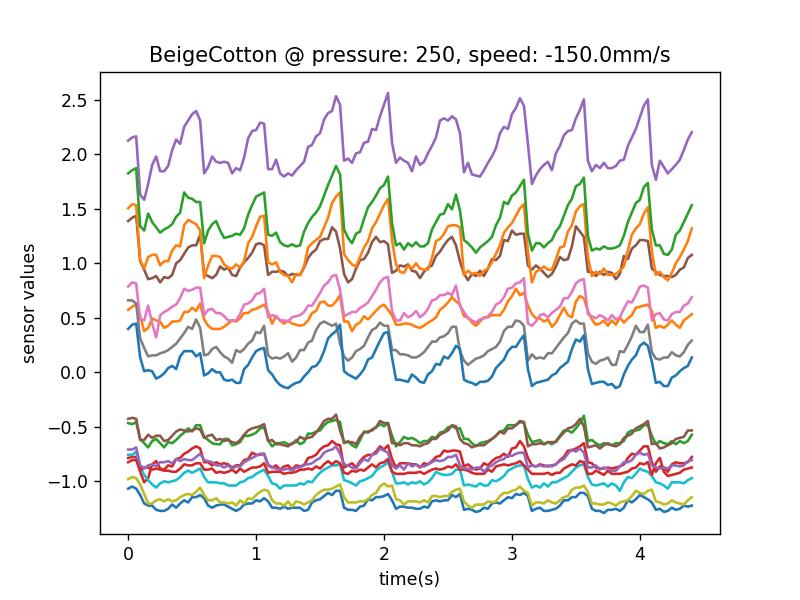

<IPython.core.display.Javascript object>


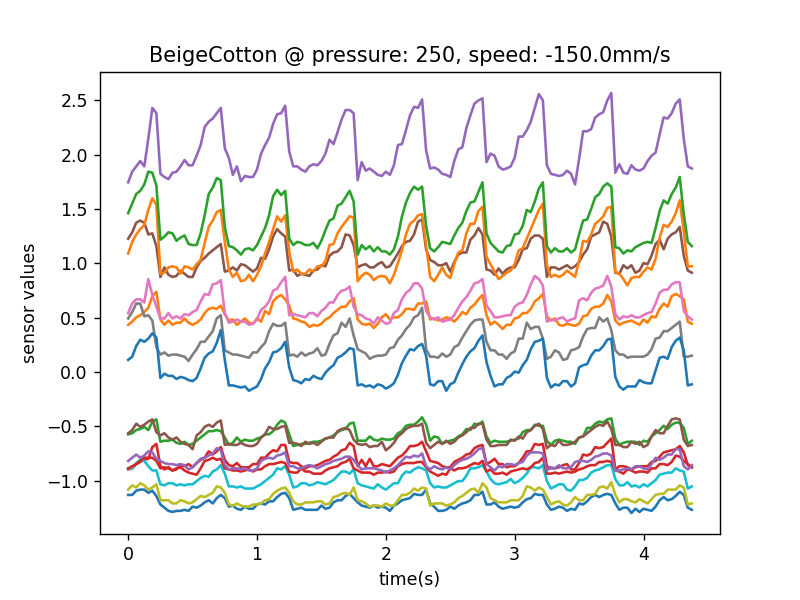

<IPython.core.display.Javascript object>


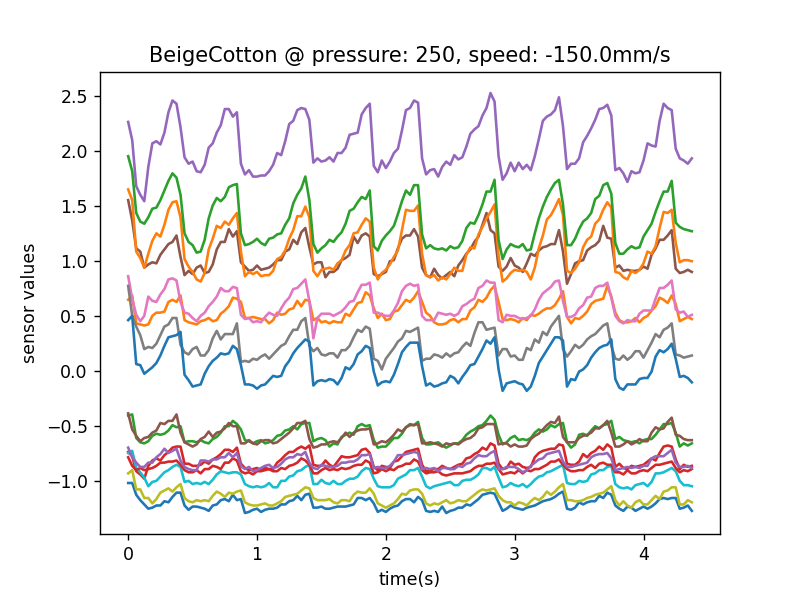

<IPython.core.display.Javascript object>


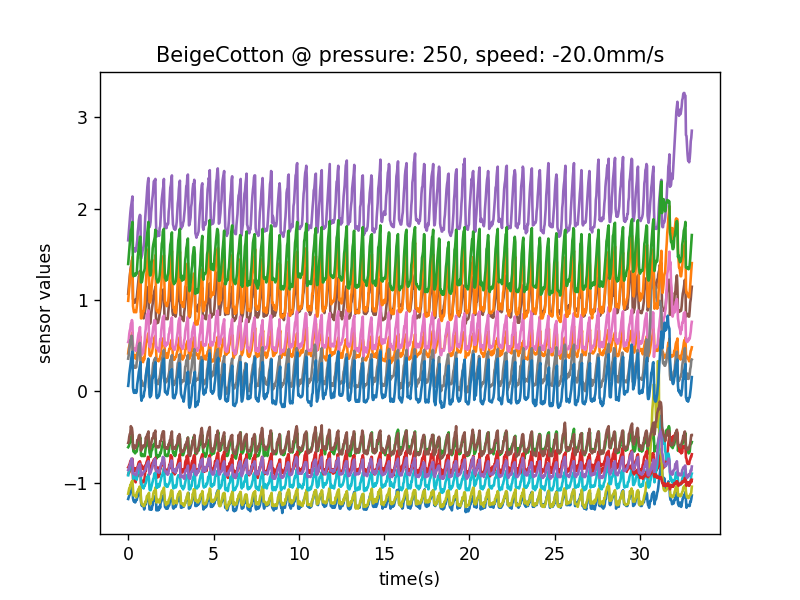

<IPython.core.display.Javascript object>


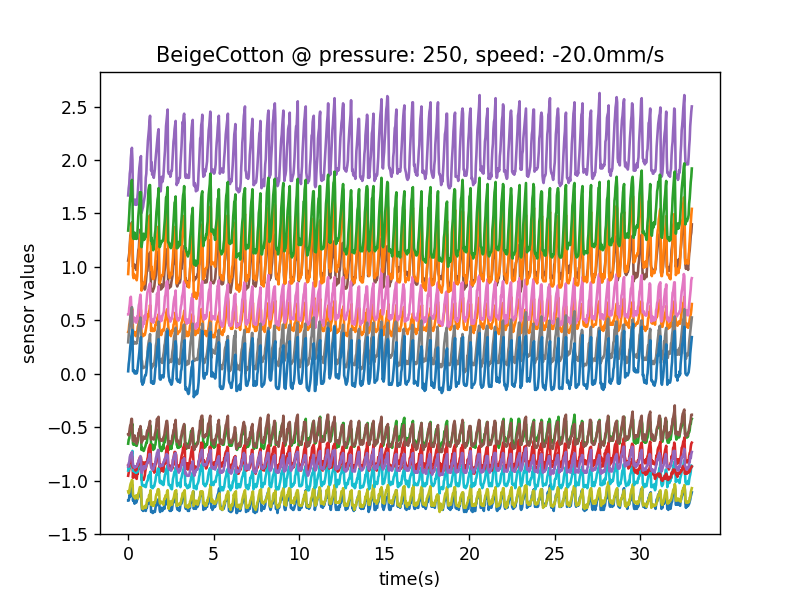

<IPython.core.display.Javascript object>


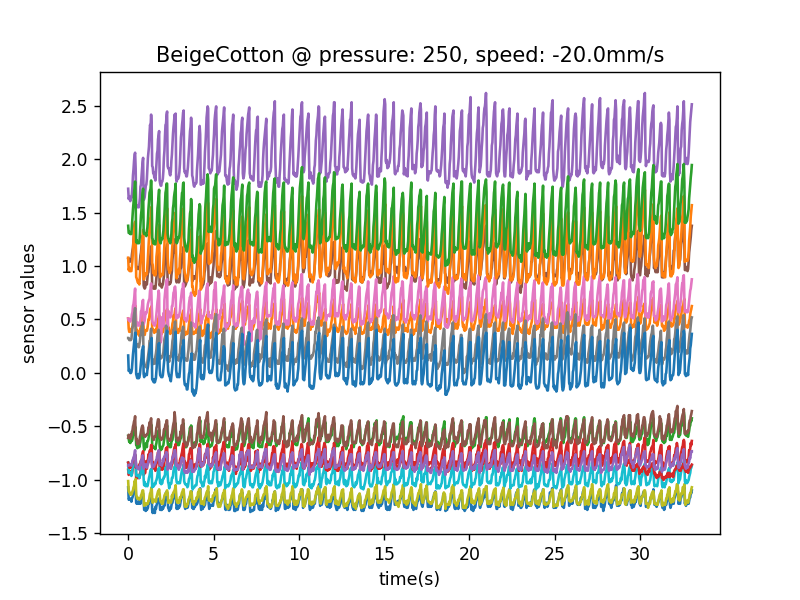

<IPython.core.display.Javascript object>


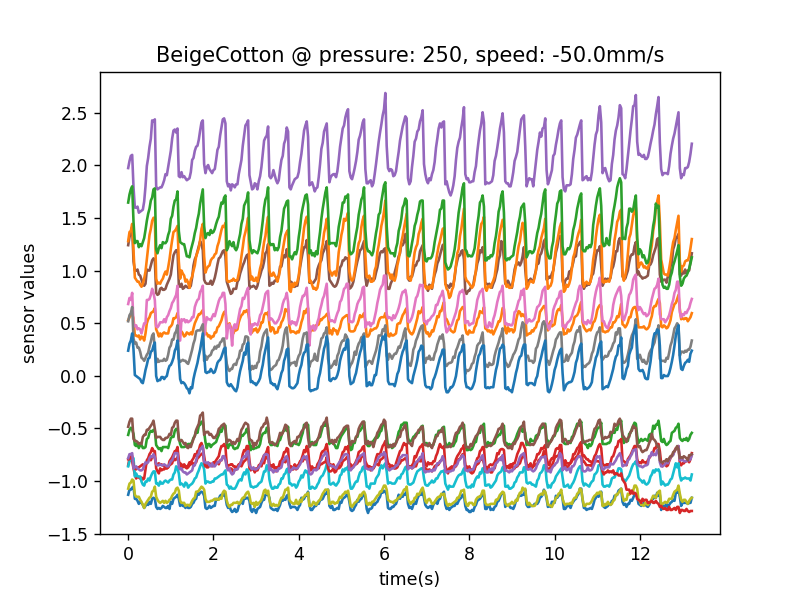

<IPython.core.display.Javascript object>


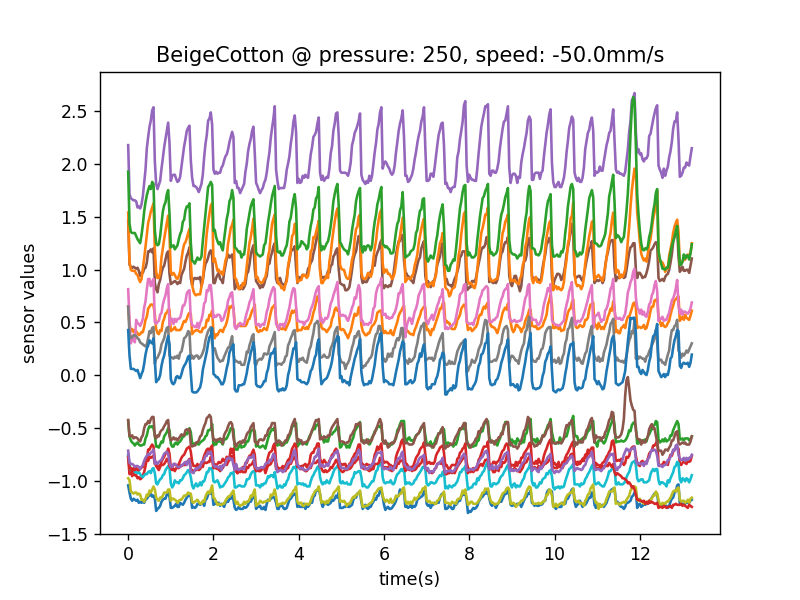

<IPython.core.display.Javascript object>


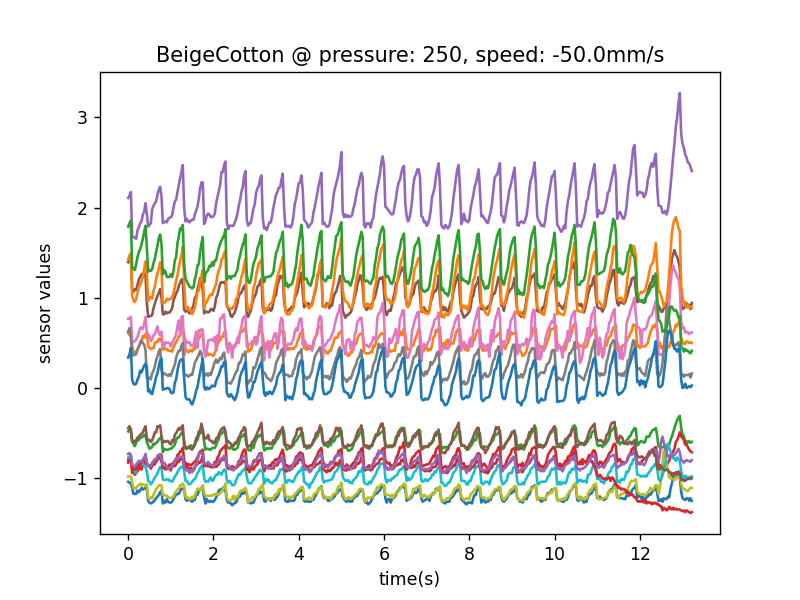

'\nplt.figure()\nplt.plot(x2, y.reshape((-1, 16)))\nplt.xticks([i+1 for i in (0, 32, 4)] + [32])\nplt.xlabel("frequency(Hz)")\nplt.ylabel("strength")\nplt.title("{} @ pressure: {}, speed: {}mm/s".format(ds.get_texture_name(label), param[0], param[1]))\nplt.show()\n'

In [28]:
import matplotlib.pyplot as plt

%matplotlib notebook

for i in range(len(ds)):
    sample, param, label = ds[i]
    if param[0] == 250 and param[1] < -10 and ds.get_texture_name(label) == "BeigeCotton":
        y = fft_resample(sample)
        x1 = np.tile(np.arange(sample.shape[0]).reshape((-1, 1))/32.0, (1, 16))
        x2 = np.tile((np.arange(32)).reshape((-1, 1))+1, (1, 16))

        plt.figure()
        plt.plot(x1, sample)
        plt.ylabel("sensor values")
        plt.xlabel("time(s)")
        plt.title("{} @ pressure: {}, speed: {}mm/s".format(ds.get_texture_name(label), param[0], param[1]))

"""
plt.figure()
plt.plot(x2, y.reshape((-1, 16)))
plt.xticks([i+1 for i in (0, 32, 4)] + [32])
plt.xlabel("frequency(Hz)")
plt.ylabel("strength")
plt.title("{} @ pressure: {}, speed: {}mm/s".format(ds.get_texture_name(label), param[0], param[1]))
plt.show()
"""

# Iterative PCA

## Methods
1. Resample the time series to the same length and transform into frequency domain
2. Flatten the $Ns \times 16$ frequency matrix into a 1D vector
3. Stack the frequency vectors into a frequency matrix

## Steps
1. Use few samples as a prior knowledge to train a PCA compressor ($Ns \times 16$D $\rightarrow 3$D)
2. For new samples, update the de-meaned frequency matrix
3. Apply iterative PCA to update the compressed frequency vector
4. Try to identify the fabric material under current *pressure* and *speed* settings

In [4]:
import pandas as pd
from numpy.fft import rfft
from scipy import signal

num = 64

# prepare data
coeff_array = []
labels = []

for i, (sample, param, label) in enumerate(ds):
    coeffs = fft_resample(sample)
    coeff_array.append(coeffs)
    # append label info
    texture, (p, s) = ds.get_texture_name(label), param
    labels.append((texture, label, p, s))

df0 = pd.DataFrame(labels, columns=["texture", "id", "pressure", "speed"])
coeffs = np.asarray(coeff_array)

In [206]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

%matplotlib notebook

def plot3d(df, items):
    unique_item = df0[items].unique()
    cmap = plt.cm.get_cmap("Paired", len(unique_item))
    colors = dict([(unique_item[i], cmap(i)) for i in range(len(unique_item))])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    for item in df[items].unique():
        df_ = df[df[items] == item]
        color = np.asarray(colors[item])
        ax.scatter(df_["x"], df_["y"], df_["z"], marker="x", s=20, c=np.tile(color, (len(df_), 1)), label=item)
    ax.legend()
    plt.tight_layout()

def extractXd(n_components=3, use_texture=2):
    # split textures into (train, test and other) 3 groups
    all_fabrics = df0[~df0["texture"].str.contains("Board")]["texture"].unique()
    np.random.shuffle(all_fabrics)

    tmp = all_fabrics[:use_texture]
    train_id = df0[df0["texture"].isin(tmp)].index
    train_label = df0.iloc[train_id]
    train_coeff = coeffs[train_id, :]

    tmp = all_fabrics[use_texture:]
    test_id = df0[df0["texture"].isin(tmp)].index
    test_label = df0.iloc[test_id]
    test_coeff = coeffs[test_id, :]

    tmp = df0[df0["texture"].str.contains("Board")]["texture"].unique()
    other_id = df0[df0["texture"].isin(tmp)].index
    other_label = df0.iloc[other_id]
    other_coeff = coeffs[other_id, :]
    
    # prepare a feature extractor(transformer) and classifier
    transformer = IncrementalPCA(n_components=n_components)

    # apply incremental PCA on train data
    transformer.partial_fit(train_coeff)
    trainXd = transformer.transform(train_coeff)
    
    return transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label

reps = 3
rate = np.zeros((reps, 10))
var_ratio = np.zeros((reps, 10))
for i in range(10):
    for j in range(reps):
        transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(i+1)
        var_ratio[j, i] = np.sum(transformer.explained_variance_ratio_[:i+1])
        testXd = transformer.transform(test_coeff)
        allXd = np.vstack([trainXd, testXd])
        allLabel = np.hstack([train_label["id"].values, test_label["id"].values])
        # Convert label to 1-hot array
        h = np.zeros((allLabel.size, allLabel.max()+1))
        h[np.arange(allLabel.size),allLabel] = 1
        
        clf = KNeighborsClassifier(10, weights="distance")
        X_train, X_test, Y_train, Y_test = train_test_split(allXd, h, test_size=0.5, random_state=42)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        rate[j, i] = accuracy_score(Y_test, Y_pred)

           z
24 -0.012458
25 -0.049475
26 -0.062719
27 -0.175795
28  0.016117
29 -0.018361
30 -0.025722
31 -0.031328
32 -0.053131
33 -0.043417
34 -0.038944
35 -0.100801
36 -0.002144
37  0.023569
38  0.017709
39 -0.028255
40 -0.074360
41 -0.039400
42  0.016865
43  0.057278
44  0.082864
45  0.635490
46  0.226505
47  0.207938
48  0.070273
49  0.041688
50  0.053928
51  0.023509
52  0.034617
53  0.049373
54  0.076591
55  0.105731
56  0.077147
57  0.068013
58  0.077498
59  0.064640
            z
204  0.182469
205  0.119748
206  0.138753
207  0.533385
208  0.520425
209  0.533976
210  0.142089
211  0.110488
212  0.086274
213  0.119238
214  0.090140
215  0.065317
216  0.343939
217  0.366135
218  0.278669
219  0.233678
220  0.190250
221  0.142302
222 -0.028955
223 -0.046531
224 -0.024558
225 -0.114206
226 -0.083749
227 -0.108220
228 -0.028116
229 -0.023282
230 -0.059991
231  0.008370
232  0.004829
233 -0.040316
234  0.021793
235 -0.012869
236 -0.034691
237 -0.020140
238 -0.034020
239 -0.028346
 

<IPython.core.display.Javascript object>


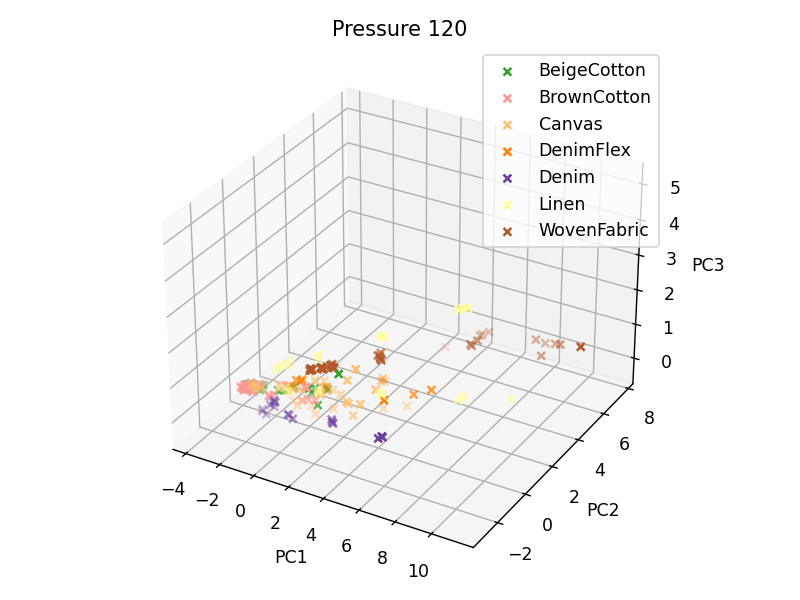

           z
60 -0.104970
61 -0.069232
62 -0.074719
63 -0.150344
64 -0.131372
65 -0.025887
66 -0.061016
67 -0.082404
68 -0.100630
69 -0.074723
70 -0.026610
71 -0.039411
72  0.082420
73  0.023048
74 -0.023424
75 -0.009731
76 -0.090912
77 -0.027602
78 -0.042546
79  0.016033
80  0.011005
81  0.076625
82  0.097089
83  0.093193
84 -0.002169
85 -0.012789
86  0.020485
87 -0.003113
88 -0.024162
89  0.035837
90  0.064341
91  0.157873
92  0.200088
93  0.172233
94  0.052067
95  0.074349
            z
240  0.065479
241  0.117484
242  0.113235
243  0.347671
244  0.380054
245  0.316485
246  0.060532
247  0.113317
248  0.092353
249  0.075068
250  0.080927
251  0.068858
252  0.207189
253  0.124574
254  0.203977
255  0.098093
256  0.130570
257  0.145664
258 -0.054688
259 -0.007542
260 -0.082296
261 -0.144107
262 -0.076106
263 -0.132175
264 -0.070070
265 -0.055792
266 -0.038053
267 -0.077795
268 -0.081031
269 -0.057525
270 -0.097413
271 -0.042432
272  0.005563
273 -0.040613
274  0.010335
275 -0.013716
 

<IPython.core.display.Javascript object>


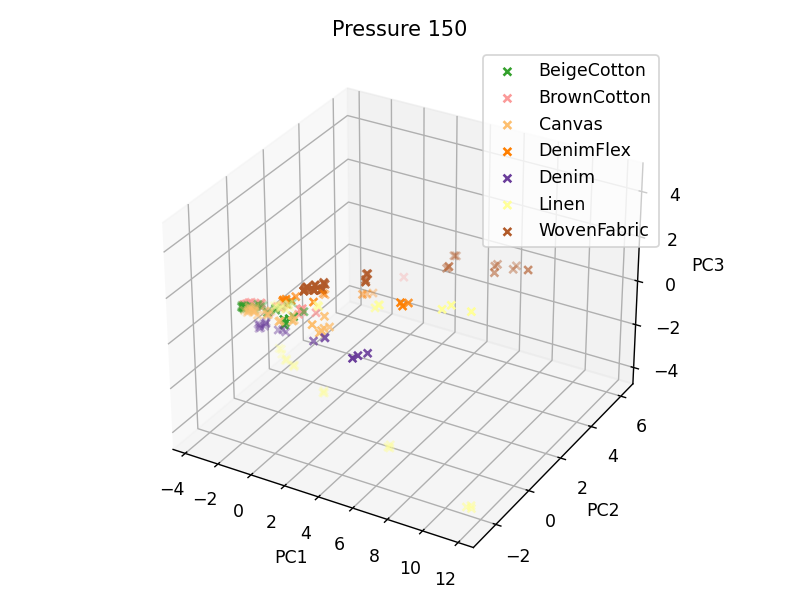

            z
96  -0.076670
97  -0.062720
98  -0.024176
99  -0.220272
100  0.074738
101 -0.040635
102 -0.106883
103  0.048849
104 -0.078822
105 -0.083183
106 -0.145529
107 -0.217024
108 -0.211709
109  0.014846
110  0.042597
111 -0.168812
112 -0.149263
113 -0.138022
114 -0.144212
115  0.015556
116  0.044960
117 -0.064032
118 -0.032506
119 -0.015275
120  0.057274
121 -0.033221
122  0.012063
123 -0.119820
124 -0.017131
125 -0.171911
126  0.031435
127 -0.065162
128 -0.028746
129 -0.134432
130 -0.023809
131 -0.074315
            z
276  0.085904
277  0.021323
278  0.006929
279  0.083888
280  0.318294
281  0.341606
282  0.050399
283  0.009595
284  0.060789
285  0.032085
286  0.011689
287  0.030573
288  0.183917
289  0.124402
290  0.098147
291 -0.001511
292  0.091673
293  0.032595
294 -0.167272
295 -0.134386
296 -0.144320
297 -0.096497
298 -0.284297
299 -0.213038
300 -0.146502
301 -0.114669
302 -0.164184
303 -0.143933
304 -0.143473
305 -0.145298
306 -0.227292
307 -0.243470
308 -0.255152
309 -0

<IPython.core.display.Javascript object>


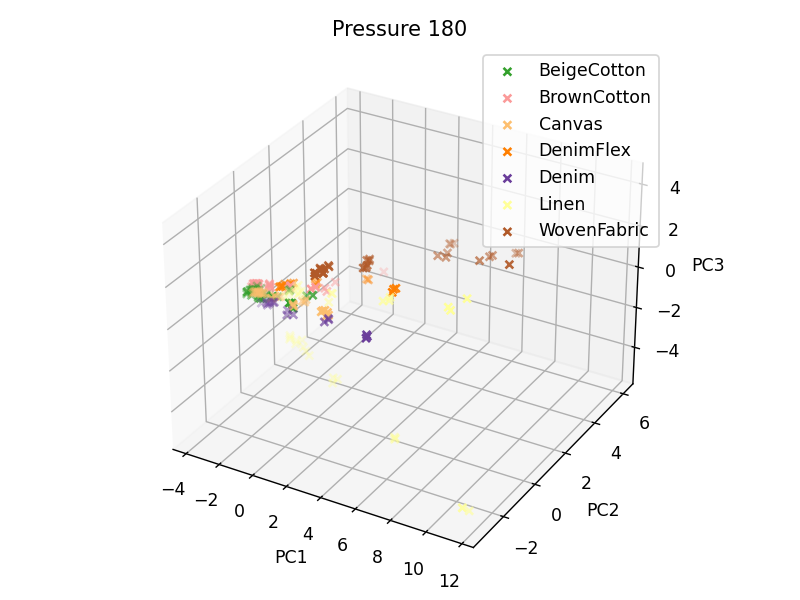

            z
132  0.270027
133  0.078932
134  0.249520
135 -0.260785
136 -0.081041
137 -0.065717
138 -0.011976
139  0.154893
140  0.372341
141 -0.524961
142  0.186243
143 -0.221238
144  0.051450
145  0.020490
146  0.068162
147  0.036590
148 -0.432737
149  0.014792
150 -0.164576
151 -0.245141
152  0.308266
153 -0.092121
154 -0.107719
155 -0.060846
156  0.141942
157  0.384628
158  0.176616
159 -0.605930
160 -0.421531
161 -0.470272
162 -0.099313
163  0.001387
164  0.152193
165 -0.024193
166 -0.116128
167  0.034482
            z
312 -0.003333
313 -0.013653
314 -0.012878
315  0.172161
316  0.193594
317  0.142218
318 -0.008958
319 -0.011186
320 -0.011115
321 -0.028161
322 -0.020659
323 -0.035324
324  0.014008
325  0.047226
326  0.011716
327 -0.010595
328 -0.000976
329  0.012664
330 -0.197235
331 -0.193728
332 -0.192550
333 -0.305255
334 -0.405328
335 -0.328113
336 -0.174402
337 -0.219103
338 -0.207595
339 -0.185846
340 -0.164327
341 -0.190322
342 -0.311046
343 -0.302026
344 -0.270780
345 -0

<IPython.core.display.Javascript object>


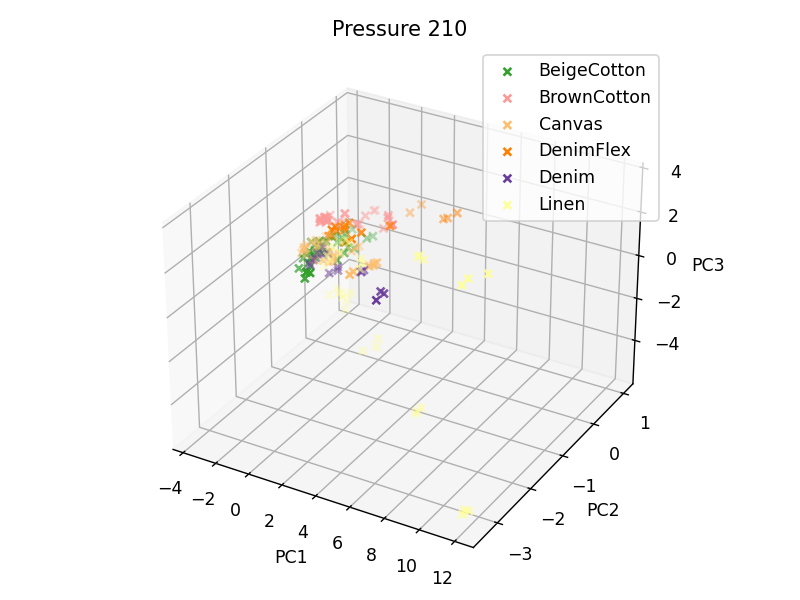

            z
168  0.239821
169 -0.537781
170 -0.945173
171 -0.149109
172 -0.130156
173 -0.222621
174 -0.148854
175  0.320503
176  0.461443
177 -0.553853
178 -0.605385
179 -0.474237
180 -0.268312
181 -0.145524
182 -0.120619
183  0.153402
184 -0.432519
185  0.173420
186 -0.169331
187 -0.964969
188 -0.793563
189  0.073828
190 -0.279903
191 -0.884941
192 -0.021400
193  0.249415
194  0.524256
195 -0.713887
196 -0.306202
197 -0.478696
198  0.743130
199 -0.072505
200  0.075382
201  0.153128
202 -0.267774
203 -0.278984
            z
348  0.137974
349  0.036243
350 -0.063462
351  0.012578
352 -0.136833
353 -0.074835
354 -0.110631
355  0.026959
356  0.018736
357 -0.522424
358 -0.300866
359 -0.369059
360 -0.149304
361 -0.124822
362 -0.011492
363 -0.362607
364 -0.197932
365 -0.287934
366 -0.074765
367  0.064640
368 -0.194213
369 -0.391102
370 -0.362838
371 -0.390380
372 -0.092498
373 -0.163661
374 -0.086345
375 -0.302603
376 -0.447113
377 -0.455035
378 -0.319999
379 -0.381361
380 -0.366532
381 -0

<IPython.core.display.Javascript object>


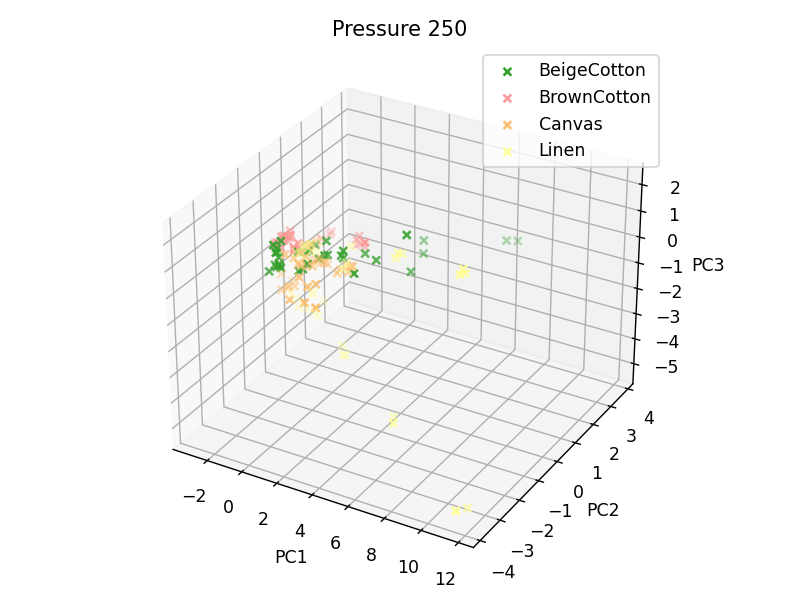

In [219]:
from scipy.stats import linregress

transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(3, 4)
coeffXd = transformer.transform(coeffs)
df1 = pd.DataFrame(coeffXd, columns=["x", "y", "z"])
df = pd.concat([df0, df1], axis=1)

df = df[~df["texture"].str.contains("Board")]
for p in df["pressure"].unique():
    df_ = df[df["pressure"] == p]
    for tex in df_["texture"].unique():
        dfx = df_[df_["texture"] == tex]
        res = linregress(dfx[["x", "y"]].values, dfx["z"])
    plot3d(df_, "texture")
    plt.title("Pressure {}".format(p))
    plt.tight_layout()

<IPython.core.display.Javascript object>


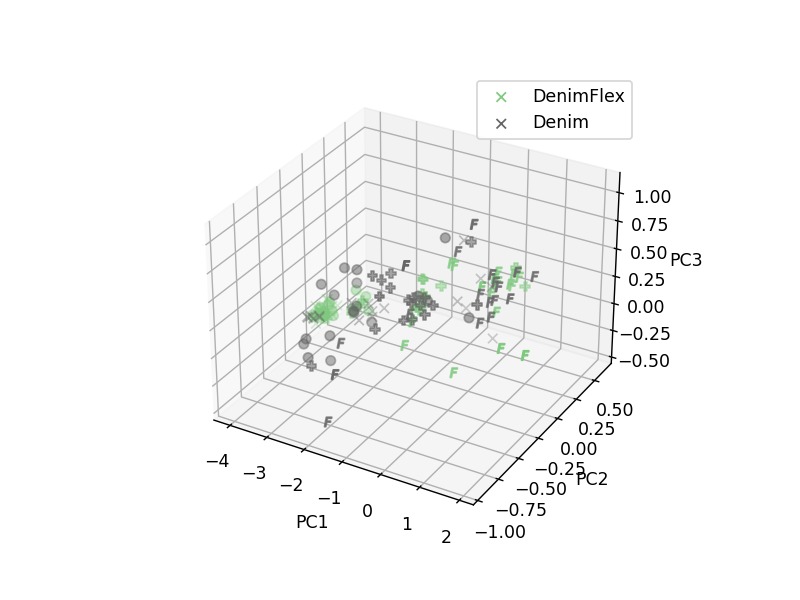

In [195]:
def mscatter(x,y,z, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    ax = ax or plt.gca()
    sc = ax.scatter(x,y,z,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(3)
testXd = transformer.transform(test_coeff)
df1 = pd.DataFrame(np.vstack([trainXd, testXd]), columns=["x", "y", "z"])
df = pd.concat([df0, df1], axis=1)
df_denims = df[df["texture"].str.contains("Denim")]

marker = dict({120: "x", 150: "o", 180: "P", 210: "$F$"})

denims = df_denim["texture"].unique()
cmap = plt.cm.get_cmap("Accent", len(denims))
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
for i, denim in enumerate(denims):
    dd = df_denims[df_denims["texture"] == denim]
    marker_list = list(map(lambda x: marker[x], dd["pressure"]))
    mscatter(dd["x"], dd["y"], dd["z"], ax=ax, m=marker_list, s=30, c=np.tile(cmap(i), (len(dd), 1)), label=denim)
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


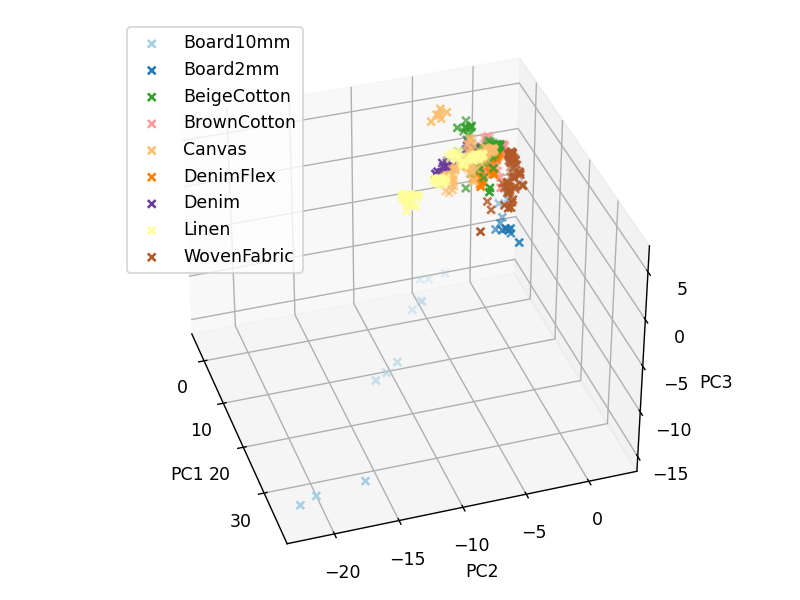

<IPython.core.display.Javascript object>


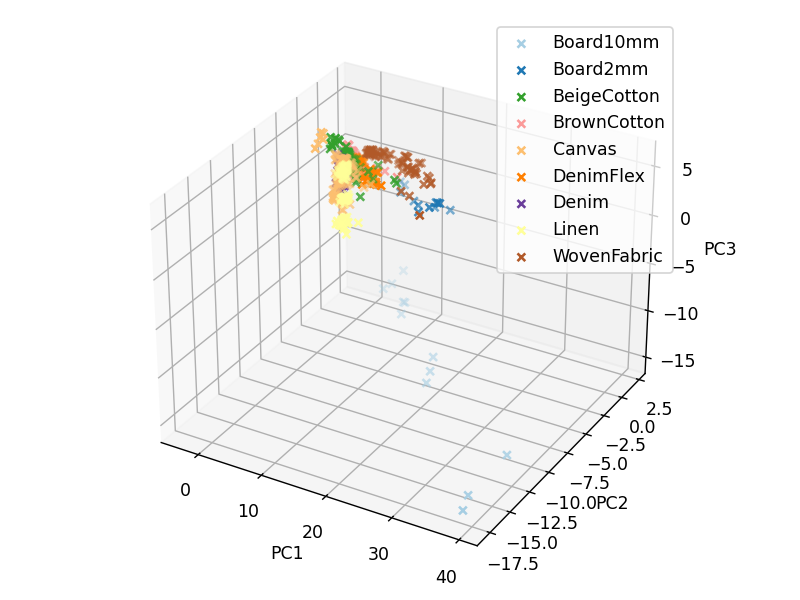

<IPython.core.display.Javascript object>


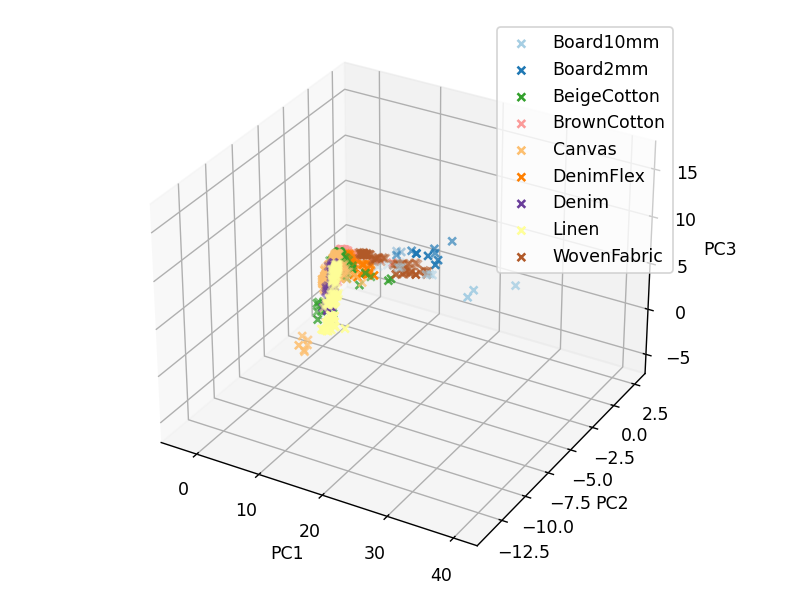

<IPython.core.display.Javascript object>


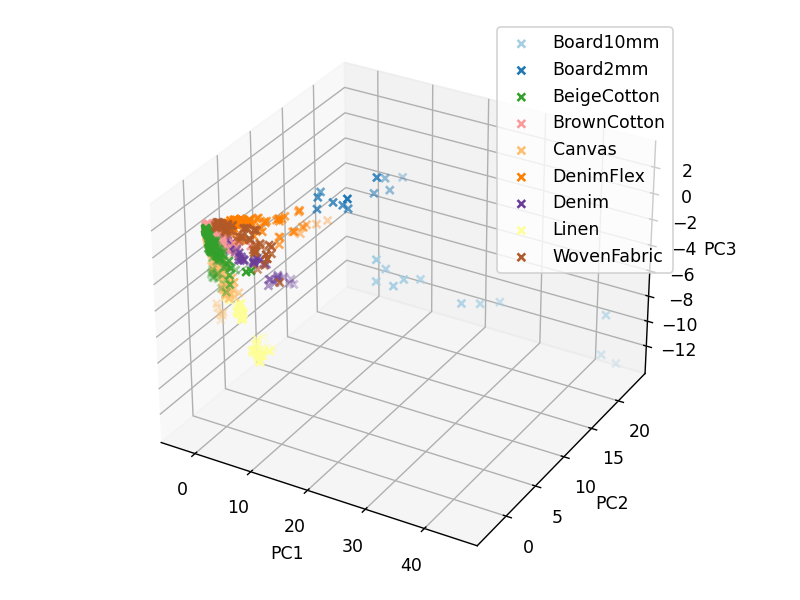

<IPython.core.display.Javascript object>


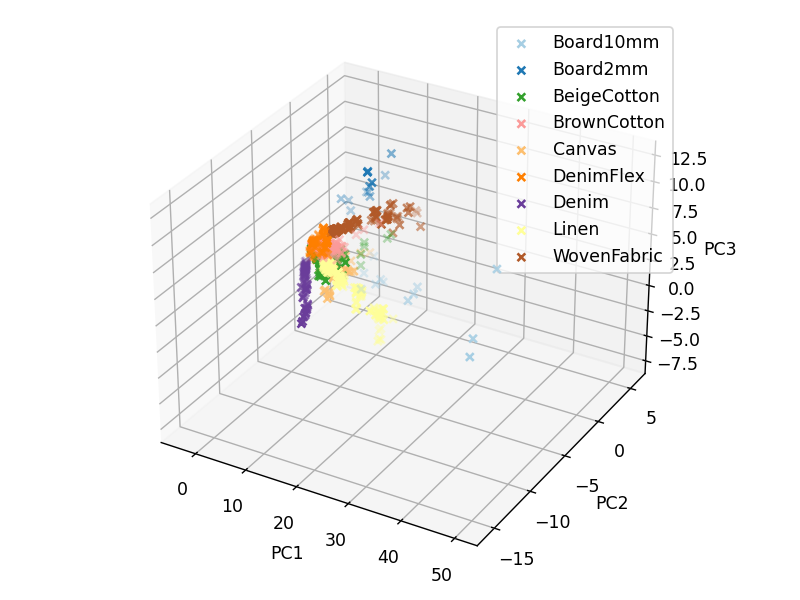

<IPython.core.display.Javascript object>


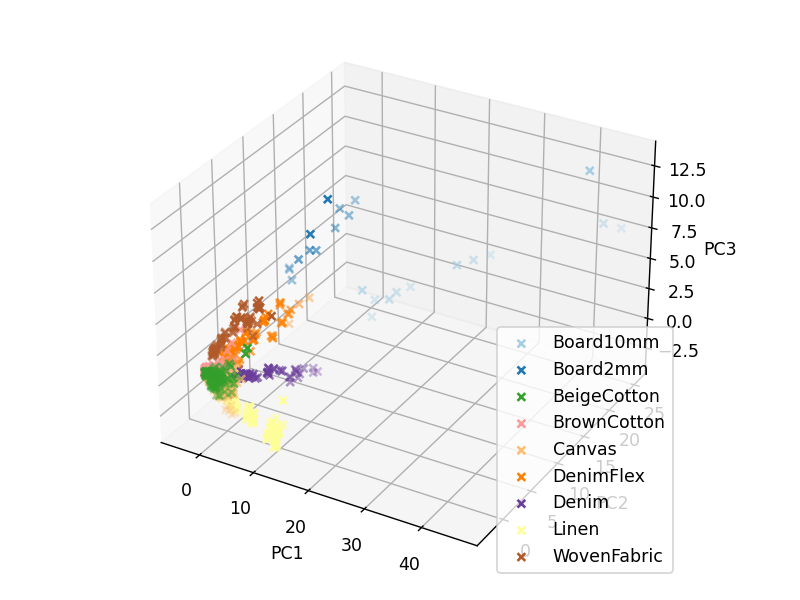

In [204]:
transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(3)

coeff_splits = np.array_split(test_coeff, 5, axis=0)
coeffXd = transformer.transform(coeffs)
df1 = pd.DataFrame(coeffXd, columns=["x", "y", "z"])
df = pd.concat([df0, df1], axis=1)
    
plot3d(df, "texture")
for coeff in coeff_splits:
    transformer.partial_fit(coeff)
    coeffXd = transformer.transform(coeffs)
    df1 = pd.DataFrame(coeffXd, columns=["x", "y", "z"])
    df = pd.concat([df0, df1], axis=1)
    
    plot3d(df, "texture")

<IPython.core.display.Javascript object>


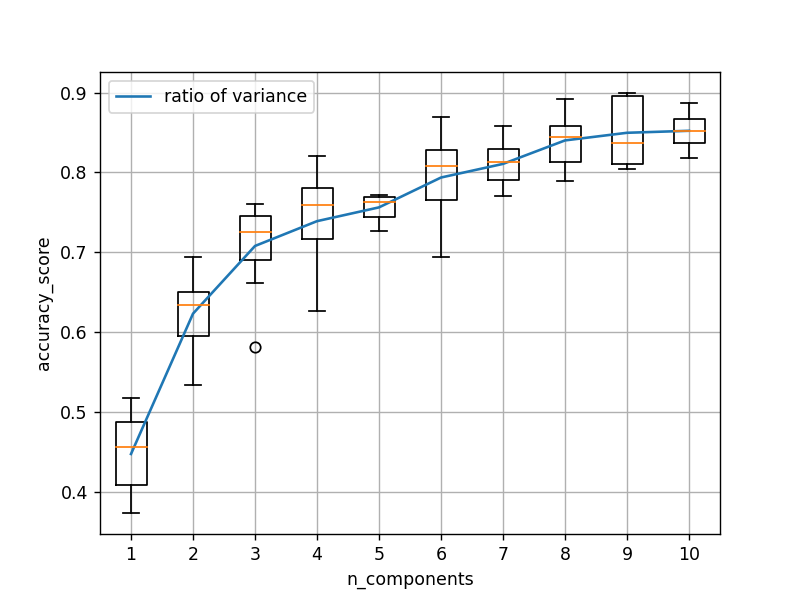

In [133]:
plt.figure()
plt.boxplot(var_ratio)
plt.plot(np.arange(10)+1, np.mean(var_ratio, axis=0), label='ratio of variance')
plt.grid()
plt.xlabel("n_components")
plt.ylabel("accuracy_score")
plt.legend()

# Construct RNN-AutoEncoder (RAE)

In [184]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence


class Encoder(nn.Module):
    """ Recurent Variational Autoencoder """
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, device, dropout=0.3):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device
        
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        self.fc_var = nn.Linear(hidden_dim, output_dim)
        
        self.to(device)
        
    def forward(self, x):
        packed_in = pack_padded_sequence(x[0].to(self.device), x[1].cpu().numpy(), batch_first=True)
        rnn_out, self.hidden = self.rnn(packed_in)
        x_in = self.hidden[-1].squeeze()
        mu = self.fc_mu(x_in)
        var = self.fc_var(x_in)
        
        return mu
    
    def init_hidden(self, batch_dim):
        return (torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device=self.device),
                torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device=self.device))


class RVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoding_dim, extra_dim, output_dim, n_layers, device):
        super(RVAE, self).__init__()
        self.device = device
        
        self.encoder = Encoder(input_dim, hidden_dim, encoding_dim, n_layers, device)
        self.classifier = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        encoded = self.encode(x[:2])
        # x_in = torch.hstack([encoded, x[2].to(self.device)])
        y = self.classifier(encoded)

        return y

    def encode(self, x):
        return self.encoder(x)
    
""" Custom collate functions"""

class PadSequence(object):
    def __call__(self, batch):
        # Each element in "batch" is a tuple (data, label).
        # Sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        # Get each sequence and pad it
        sequences = [torch.tensor(x[0], dtype=torch.float) for x in sorted_batch]
        sequences_padded = pad_sequence(
            sequences, batch_first=True)
        # Store the length of each sequence
        lengths = torch.tensor([len(x) for x in sequences])
        params = torch.tensor(list(map(lambda x: x[1], sorted_batch)), dtype=torch.float)
        labels = torch.tensor(list(map(lambda x: x[2], sorted_batch)))
        return sequences_padded, lengths, params, labels

# Train the network

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.utils.data import DataLoader

BATCH_SIZE = 8
EPOCHS = 10
INPUT_DIM = 16
NUM_CLASS = ds.count_class()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

train_loader = DataLoader(ds, batch_size=BATCH_SIZE, collate_fn=PadSequence(), num_workers=6, shuffle=True)
rvae = RVAE(input_dim=INPUT_DIM, hidden_dim=16, encoding_dim=3, extra_dim=2, output_dim=NUM_CLASS, n_layers=3, device=device)
loss_list = []

def train_once(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x)
    target = y.to(device)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    return loss.item()
    
def train_model(data_loader, model):
    optimizer = optim.SGD(model.parameters(), lr = 1e-3)
    criterion = nn.CrossEntropyLoss()
    # loss_list = []
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        
        for i, (batch, lengths, params, targets) in enumerate(data_loader):
            loss = train_once((batch, lengths, params), targets, model, optimizer, criterion)
            running_loss += loss
            loss_list.append(loss)
            
            if i % 10 == 9:
                print('Epoch {}, {:.2f}% - loss: {:.6f}'.format(epoch + 1, 100.0 * (i + 1.0) / len(data_loader), running_loss / 10))
                running_loss = 0.0
                
    print("Training finished.")
    plt.figure()
    plt.plot(loss_list)
    plt.title("Training Recurrent Autoencoder")
    plt.xlabel("Run")
    plt.ylabel("Loss")
    plt.show()
    
train_model(train_loader, rvae)